<a href="https://colab.research.google.com/github/sumanyurosha/tensorflow-specialization/blob/master/Course4/Practice/Week_4_Lesson_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%204%20Lesson%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size + 1))
    dataset = dataset.map(lambda w: (w[:-1], w[1:]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [4]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [5]:
from tensorflow import keras

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", 
                        activation="relu", input_shape=[None, 1]),
    keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True)),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*100)
  
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch/20)
)
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 11s 19ms/step - loss: 55.2143 - mae: 55.7131
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 54.3033 - mae: 54.8020
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 54.2435 - mae: 54.7424
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 53.9126 - mae: 54.4113
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 54.6329 - mae: 55.1315
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 53.2992 - mae: 53.7981
Epoch 7/100
8/8 [==============================] - 0s 12ms/step - loss: 51.9168 - mae: 52.4156
Epoch 8/100
8/8 [==============================] - 0s 12ms/step - loss: 51.4700 - mae: 51.9688
Epoch 9/100
8/8 [==============================] - 0s 13ms/step - loss: 50.8243 - mae: 51.3231
Epoch 10/100
8/8 [==============================] - 0s 12ms/step - loss: 50.1120 - mae: 50.6106
Epoch 11/100
8/8 [==============================

(1e-08, 0.0001, 0.0, 30.0)

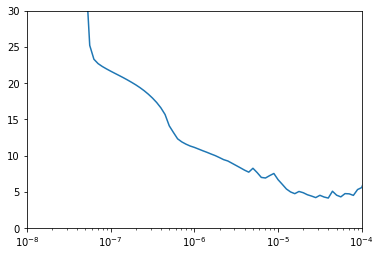

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 2s 7ms/step - loss: 27.1840 - mae: 27.6788
Epoch 2/500
31/31 [==============================] - 0s 6ms/step - loss: 9.1549 - mae: 9.6423
Epoch 3/500
31/31 [==============================] - 0s 6ms/step - loss: 7.5061 - mae: 7.9896
Epoch 4/500
31/31 [==============================] - 0s 6ms/step - loss: 6.5844 - mae: 7.0664
Epoch 5/500
31/31 [==============================] - 0s 6ms/step - loss: 5.8625 - mae: 6.3404
Epoch 6/500
31/31 [==============================] - 0s 6ms/step - loss: 5.9081 - mae: 6.3889
Epoch 7/500
31/31 [==============================] - 0s 6ms/step - loss: 5.6753 - mae: 6.1550
Epoch 8/500
31/31 [==============================] - 0s 7ms/step - loss: 5.2984 - mae: 5.7780
Epoch 9/500
31/31 [==============================] - 0s 6ms/step - loss: 5.5871 - mae: 6.0665
Epoch 10/500
31/31 [==============================] - 0s 6ms/step - loss: 5.8935 - mae: 6.3760
Epoch 11/500
31/31 [==============================] - 0s 

In [10]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

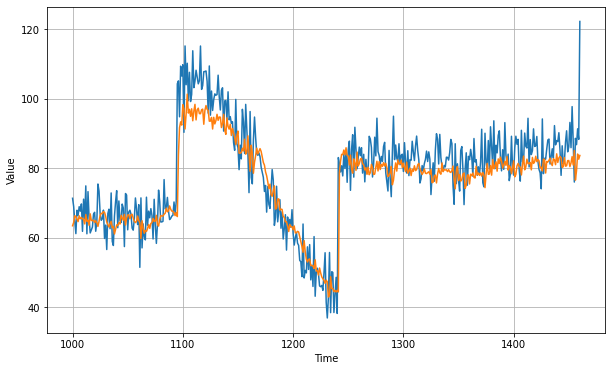

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.5114694

<Figure size 432x288 with 0 Axes>

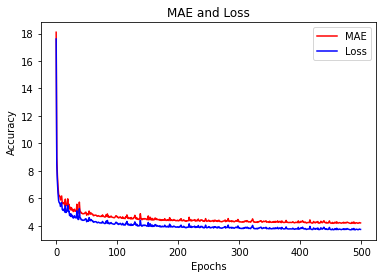

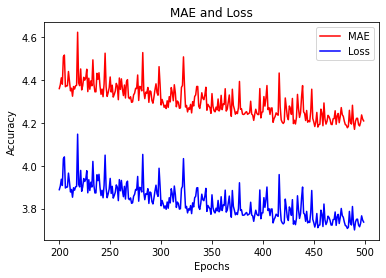

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()